<a href="https://colab.research.google.com/github/tgundavelli/Computer-Vision/blob/main/Window_Based_Scan_Line_Stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 6: Dense Stereo
In this lab, you will implement window-based stereo and scan-line stereo given two images. You will also get faimilar with the trick of integral image to accelerate window-based stereo algorithm.

Related lecture note: http://mengtang.org/cse185/files/lec09_2_stereo.pdf

(-0.5, 383.5, 287.5, -0.5)

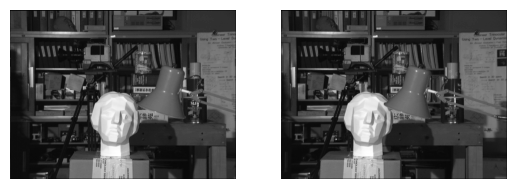

In [ ]:
# read left image and right image
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

import urllib.request
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/stereo_left.ppm", "stereo_left.ppm")
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/stereo_right.ppm", "stereo_right.ppm")

imL = image.imread("stereo_left.ppm")
imR = image.imread("stereo_right.ppm")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)
plt.subplot(1,2,1)
plt.imshow(imLgray, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(imRgray, cmap='gray')
plt.axis("off")

##Part 1: Window-based stereo
Complete the function windowed_stereo bellow which computes stereo based on sum of differences of two windows on the left and right images.

In [ ]:
def windowed_stereo(imgL, imgR, max_disparity=30, window_size=3):

    W = imgL.shape[1];
    H = imgL.shape[0];
    window_half_size = window_size //2
    # create the disparities image:
    Disparities = np.zeros([H, W], dtype=np.uint8);

    # loop over the image
    for x in range(window_half_size, W-window_half_size):

        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x-window_half_size, max_disparity]);
        if(max_disp >= 0):
            disps = np.arange(0, max_disp+1, dtype=np.uint8);
            differences = np.zeros([len(disps), 1], dtype=np.float32);

            for y in range(window_half_size, H-window_half_size):
                # Complete the function here
                window_left = imgL[y - window_half_size:y + window_half_size + 1, x - window_half_size:x + window_half_size + 1]

                for d in disps:
                    # Complete the function here
                    window_right = imgR[y - window_half_size:y + window_half_size + 1, x - window_half_size - d:x + window_half_size - d + 1]
                    # Complete the function here
                    differences[d] = np.sum(np.abs(window_left - window_right))

                # the minimal difference determines the disparity
                disparity = disps[np.argmin(differences)]
                Disparities[y, x] = disparity;

    return Disparities;

Visualze disparity map, experiment with different window size(window_size=3,5 or 7), and see the different results obtained. Measure the time it takes to compute stereo.

It takes 43.81172442436218 seconds to compute stereo!


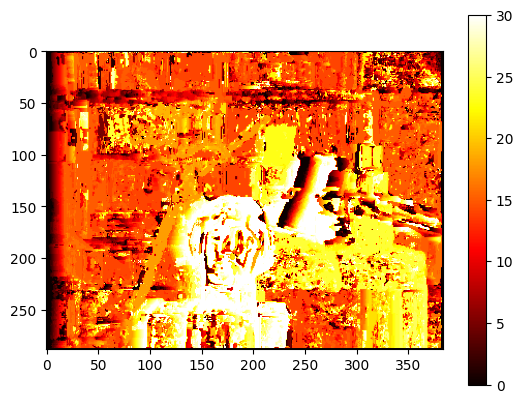

In [ ]:
import time

start=time.time()
disparity_map = windowed_stereo(imLgray, imRgray, max_disparity=30, window_size=3);
print(f"It takes {time.time()-start} seconds to compute stereo!")
plt.figure();
plt.imshow(disparity_map, cmap='hot');
plt.colorbar();
plt.draw()

Implement a fast version of the window-based stereo algorithm by using integral image. Measure the speedup compared to naive implementation.

It takes 36.59587335586548 seconds to compute stereo using the trick of integral image!


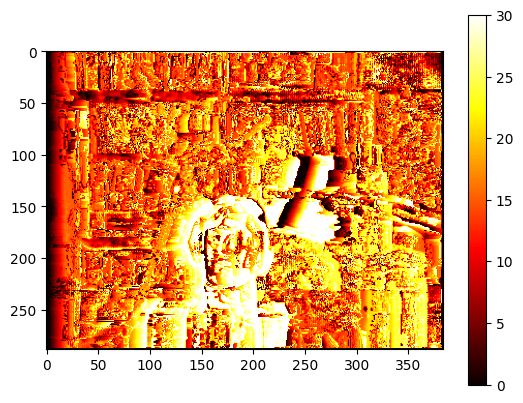

In [ ]:
def windowed_stereo_fast(imgL, imgR, max_disparity=30, window_size=7):

    W = imgL.shape[1];
    H = imgL.shape[0];
    window_half_size = window_size //2

    integral_imgL=np.cumsum(np.cumsum(imgL,axis=0),axis=1)
    integral_imgR=np.cumsum(np.cumsum(imgR,axis=0),axis=1)

    # create the disparities image:
    Disparities = np.zeros([H, W]);

    # loop over the image
    for x in np.arange(window_half_size, W-window_half_size):

        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x-window_half_size, max_disparity]);
        if(max_disp >= 0):
            disps = np.arange(0, max_disp+1);
            differences = np.zeros([len(disps), 1]);

            for y in np.arange(window_half_size, H-window_half_size):
                # Complete the function here
                #window_left = integral_imgL[y - window_half_size:y + window_half_size + 1, x - window_half_size:x + window_half_size + 1]
                x1, x2 = x - window_half_size, x + window_half_size
                y1, y2 = y - window_half_size, y + window_half_size
                window_left = integral_imgL[y2,x2] - integral_imgL[y1-1,x2] - integral_imgL[y2,x1-1] + integral_imgL[y1-1,x1-1]

                for d in disps:
                    x1_r, x2_r = x - window_half_size - d, x + window_half_size - d
                    y1_r, y2_r = y - window_half_size, y + window_half_size
                    # Complete the function here
                    window_right = integral_imgR[y2_r,x2_r] - integral_imgR[y1_r - 1,x2_r] - integral_imgR[y2_r,x1_r - 1] +integral_imgR[y1_r - 1,x1_r - 1]
                    # Complete the function here
                    differences[d] = np.sum(np.abs(window_left - window_right))

                # the minimal difference determines the disparity
                disparity = disps[np.argmin(differences)]
                Disparities[y, x] = disparity;

    return Disparities;

start=time.time()
disparity_map = windowed_stereo_fast(imLgray, imRgray, max_disparity=30, window_size=3);
print(f"It takes {time.time()-start} seconds to compute stereo using the trick of integral image!")
plt.figure();
plt.imshow(disparity_map, cmap='hot');
plt.colorbar();
plt.draw()

##Part 2: Scan-line stereo
Implement scan-line stereo using dynamic programming. The optimization objective is the sum of a data term and a pairwise regularization term.

$E(d)=\sum_{p\in S}D_p(d_p)+ w\cdot \sum_{p\in S}V_p(d_p,d_{p+1})$

where $D_p(d_p) = |I^{right}_p - I^{left}_{p+d_p}|$ is a photo-consistency term and $V_p(d_p, d_{p+1})$ is a pairwise regularization term.

Experiment with different weight $w$ of the regularization term.

<ipython-input-28-1d3ad577a84f>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Disparities = np.zeros_like(imgL, dtype=np.int)


It takes 1.5488927364349365 seconds to compute scan-line stereo!


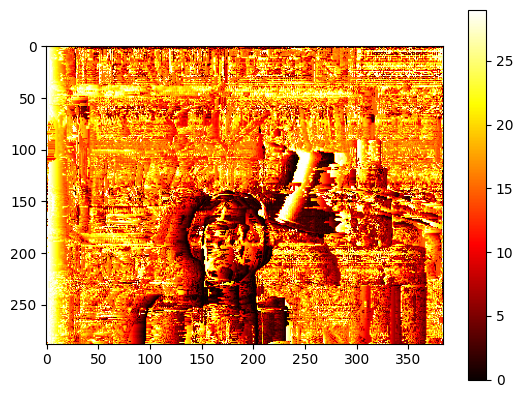

In [ ]:
import numpy as np

# Scanline stereo matching
def scanline_stereo(imgL, imgR, max_disp=30, w=2):

    H = imgL.shape[0]
    W = imgL.shape[1]

    cost_volume = np.zeros((imL.shape[0], imgL.shape[1], max_disp), dtype=float)

    padded_imgR = np.pad(imgR, ((0, 0), (max_disp, 0)), 'constant', constant_values=0)

    for d in range(max_disp):
      cost_volume[:, :, d] = np.abs(imgL - padded_imgR[:, d:d + imgL.shape[1]])

    Disparities = np.zeros_like(imgL, dtype=np.int)

    accumulated_costs = np.zeros((imgL.shape[0], imgL.shape[1], max_disp), dtype=float)

    accumulated_costs[0] = cost_volume[0]

    for row in range(1, H):
        for d in range(max_disp):
            min_prev_cost = np.min(accumulated_costs[row - 1, max(0, d - 1):d + 2])
            accumulated_costs[row, :, d] = cost_volume[row, :, d] + min_prev_cost

    for row in reversed(range(H)):
        for col in reversed(range(W)):
            if col == 0:
                Disparities[row, col] = np.argmin(accumulated_costs[row, col])
            else:
                prev_disp = Disparities[row, col - 1]
                prev_col = col - prev_disp
                min_prev_cost = np.min(accumulated_costs[row, max(0, prev_disp - 1):prev_disp + 2])
                total_cost = cost_volume[row, col, prev_disp] + min_prev_cost
                Disparities[row, col] = np.argmin(accumulated_costs[row, col])
    return Disparities

start=time.time()
disparity_map = scanline_stereo(imLgray, imRgray, max_disp=30, w=2);
print(f"It takes {time.time()-start} seconds to compute scan-line stereo!")
plt.figure();
plt.imshow(disparity_map, cmap='hot');
plt.colorbar();
plt.draw()